In [1]:
import ee
import pandas as pd
import numpy as np
import itertools
from tqdm.auto import tqdm
import plotnine
from plotnine import *

In [2]:
# authenticate earthengine api
ee.Initialize()

In [3]:
from Modules.Modules import get_img_df,filter_exclude, stats_GAEZ_Yearbook

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [4]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# get the admin shp
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

In [5]:
# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

In [6]:
# set the scale to convert GYGA_pential to GYGA_attainable
GYGA_convert_scale = 0.8

### Get the GYGA data

In [7]:
# read GYGA (global yield gap atlas) data
GYGA = pd.read_csv('../../Data/06_Yearbook/Agricultural_production/GYGA/GygaChina_Crop_potential_yield.csv')

# split station_name into city_name and province_name
GYGA['City'] = GYGA['STATIONNAME'].apply(lambda x:x.split('(')[0].strip())
GYGA['Province'] = GYGA['STATIONNAME'].apply(lambda x:x.split('(')[1][:-1].strip())

# split CROP into CROP and Irrigation
GYGA['crop'] = GYGA['CROP'].apply(lambda x:x.split(' ')[1].strip())
GYGA['water'] = GYGA['CROP'].apply(lambda x:x.split(' ')[0].strip())

# filter the rows that area in the research provinces
GYGA = GYGA[GYGA['Province'].isin(list(city_cn_en.values()))].sort_values('Province').reset_index(drop=True)

# remove unnucessay cols
GYGA = GYGA[['Province','City','crop','water','YW','YP']]

# rename crop to match GAEZ records
crop_rename_dict = {'rice':'Wetland_rice','wheat':'Wheat','maize':'Maize'}
GYGA = GYGA.replace(crop_rename_dict)

In [8]:
# divide GYGA into rainfed/irrigated
GYGA_rainfed = GYGA[GYGA['water']=='Rainfed'].rename(columns={'YW':'yield_potential'}).drop(columns='YP')
GYGA_irrigated = GYGA[GYGA['water']=='Irrigated'].rename(columns={'YP':'yield_potential'}).drop(columns='YW')

# concat GYGA data
GYGA_YP = pd.concat([GYGA_rainfed,GYGA_irrigated]).reset_index(drop=True)

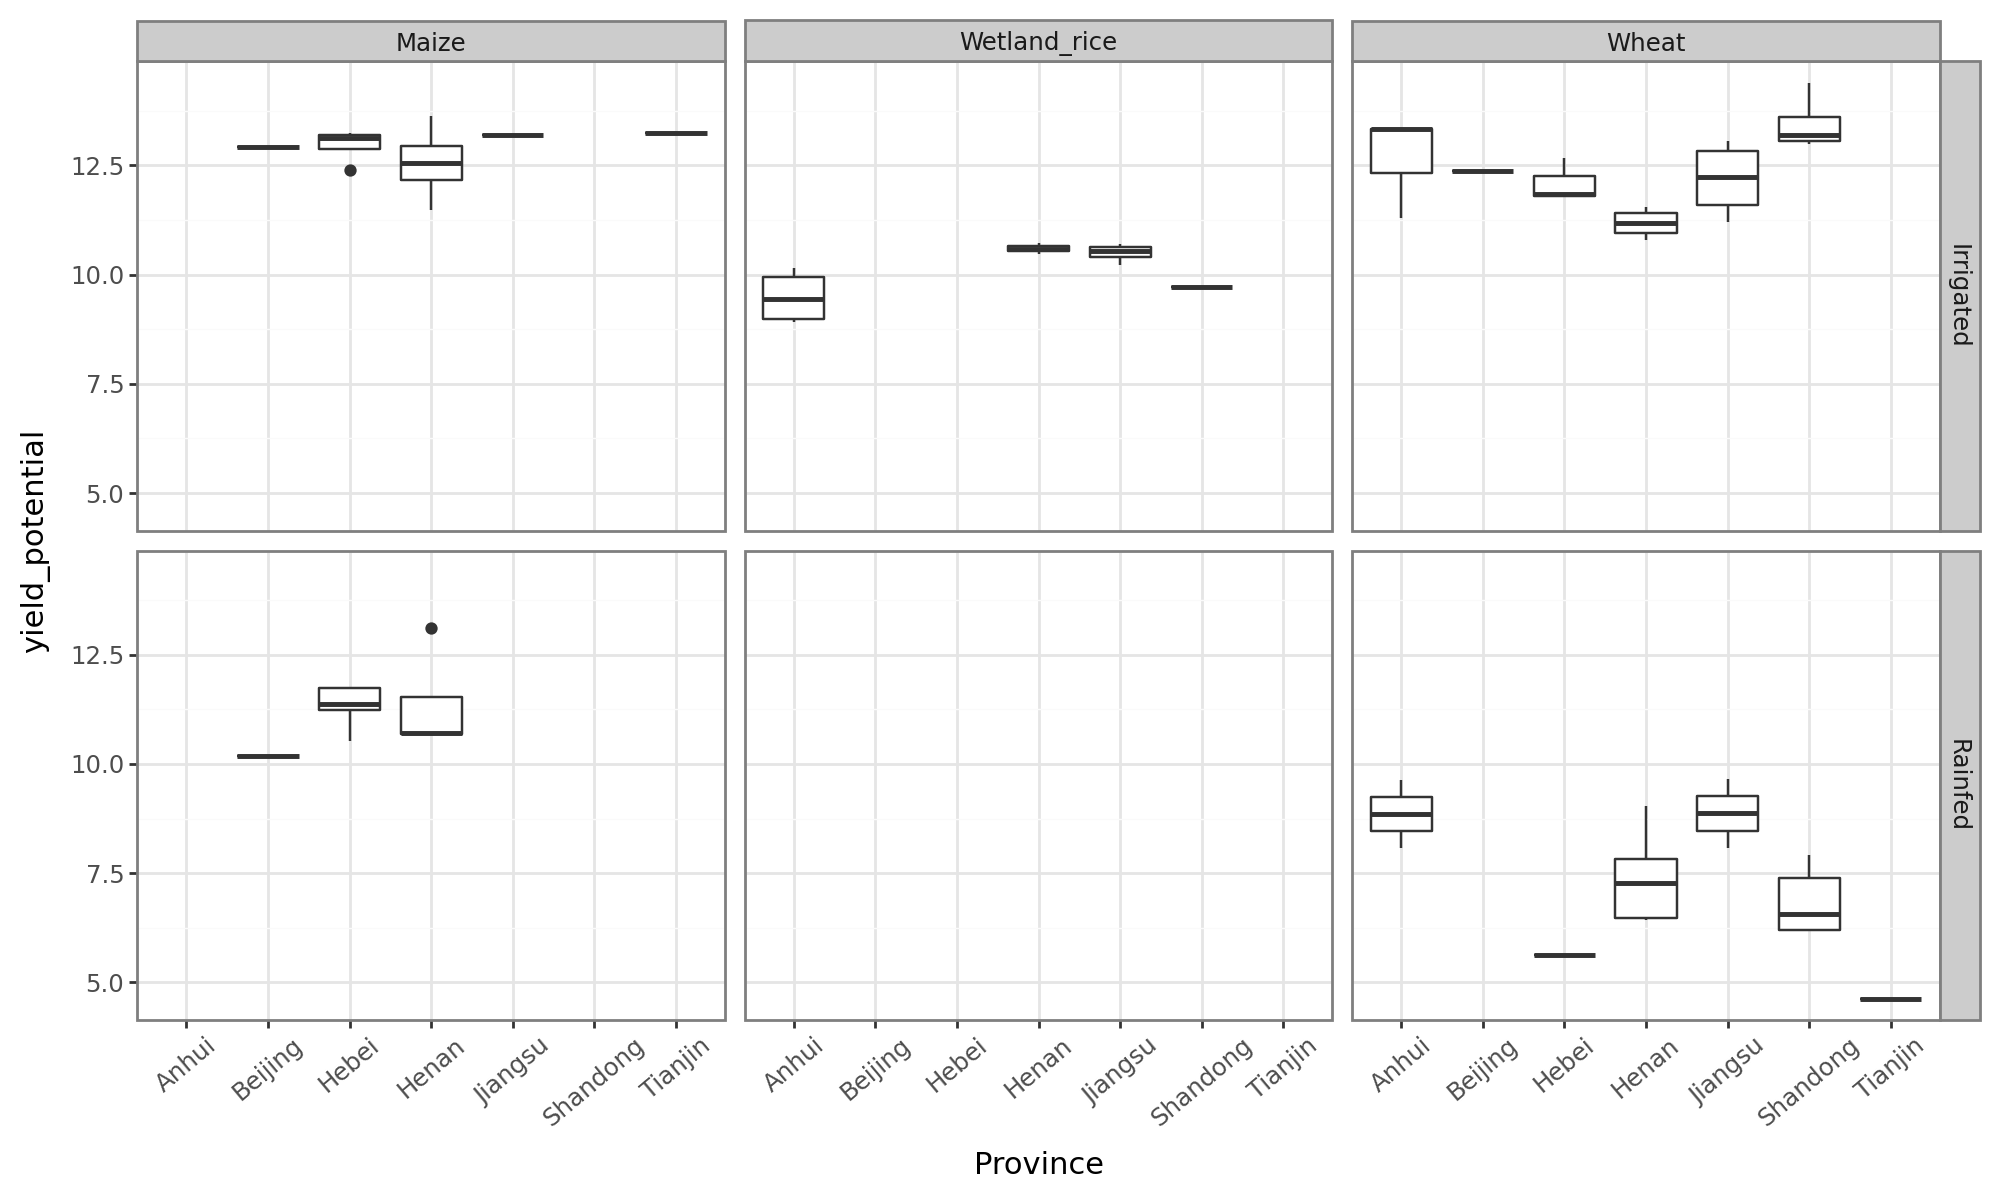

In [9]:
# plot the GYGA attainable yield
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 100

(ggplot(GYGA_YP,aes(x='Province',y='yield_potential')) +
 geom_boxplot() +
 facet_grid('water~crop') +
 theme_bw(base_size=11) +
 theme(axis_text_x=element_text(rotation=40))
)

### Fill the missing values using mean

In [10]:
# compute the mean values of existing records
GYGA_mean = GYGA_YP.groupby(['Province','crop','water'])['yield_potential'].mean().reset_index()

In [11]:
# find missing combinations
All_combinations = itertools.product(GYGA_YP['Province'].unique(),GYGA_YP['crop'].unique(),GYGA_YP['water'].unique())
Exist_combinations = zip(GYGA_mean['Province'],GYGA_mean['crop'],GYGA_mean['water'])

lack_combinations = set(list(All_combinations)) - set(list(Exist_combinations))

In [12]:
# innitiate an empty df using lack_combinations
null_df = pd.DataFrame({i:[np.nan] for i in lack_combinations}).T.reset_index()
null_df.columns = GYGA_mean.columns

# function to compute mean YP give crop/water
def get_mean(crop,water):
  mean = GYGA_YP[(GYGA_YP['crop']==crop)&(GYGA_YP['water']==water)]['yield_potential'].mean()
  return mean

# concat null_df with GYGA
null_df['yield_potential'] = null_df.apply(lambda x: get_mean(x['crop'],x['water']),1)

# lastly, fill rainfed-rice with 0
null_df = null_df.fillna(0)

# append filling data
GYGA_fill = pd.concat([GYGA_YP,null_df])

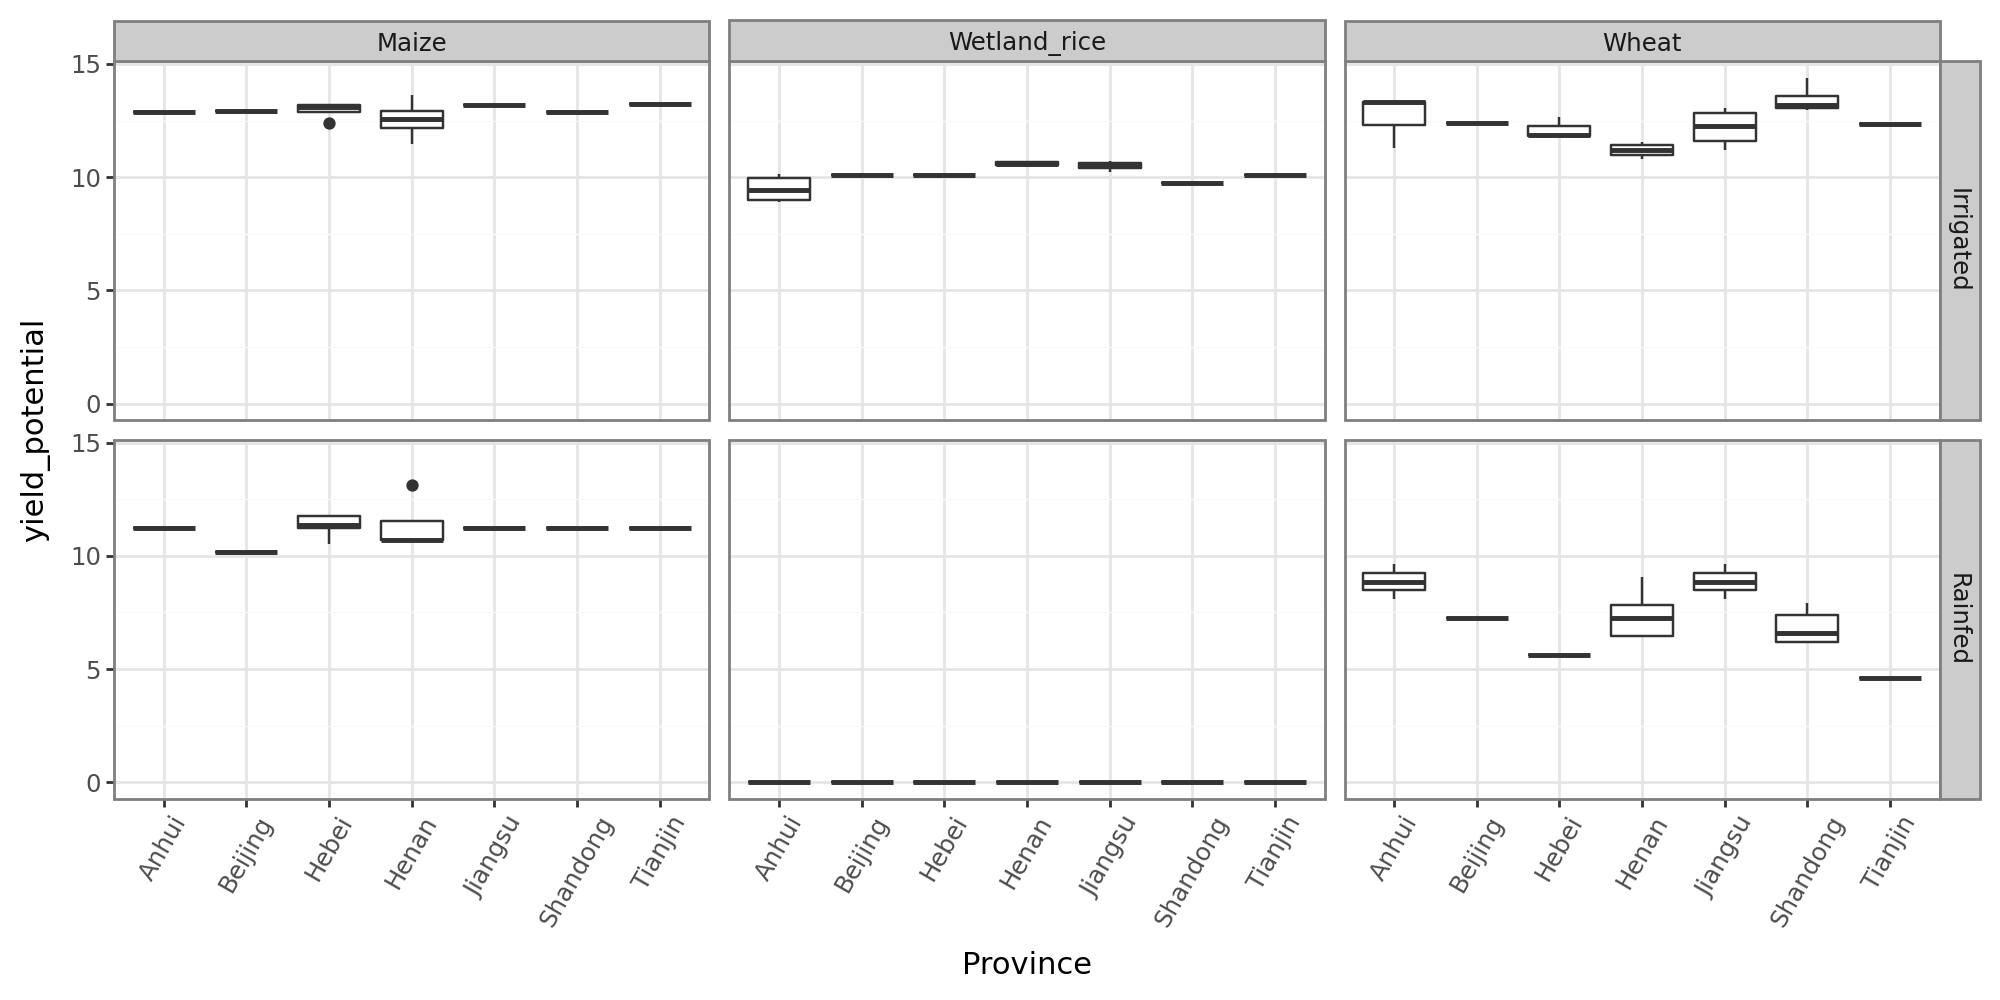

In [13]:
# plot the filled GYGA data
plotnine.options.figure_size = (10, 5)
plotnine.options.dpi = 100

g = (ggplot(GYGA_fill,aes(x='Province',y='yield_potential')) +
 geom_boxplot() +
 facet_grid('water~crop') +
 theme_bw(base_size=11) +
 theme(axis_text_x=element_text(rotation=60))
)
g

In [ ]:
g.save('/content/sup_13_GYGA_attainable_yield.svg')

#### Compute the harvested area ratio for each province so we get the mean yield

In [14]:
# actual harvested area
actual_area = get_img_df(img_path = GAEZ_list,
              theme = 'GAEZ_5',
              variable = ['Harvested_area'],
              time = '2010',
              crop = ['Maize','Wetland_rice','Wheat'],
              water = ['Rainfed','Irrigated'])

In [15]:
actual_area['Province'] = None
actual_area['area_ratio'] = None

stats_dfs = []
for idx,row in tqdm(actual_area.iterrows(),total=len(actual_area)):
  crop = row['crop']
  water = row['water']
  img = ee.Image(row['GEE_path'])

  stats = img.reduceRegions(collection=NCP_provinces,scale=GAEZ_pix_scale,reducer='sum').getInfo()
  stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] for i in stats['features']}).T.reset_index()
  stats_df.columns = ['Province','area']

  stats_df['crop'] = crop
  stats_df['water'] = water

  stats_dfs.append(stats_df)

  0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
# get the harvested area (ha) for each province
area_water_each_province = pd.concat(stats_dfs)
area_total_each_province = area_water_each_province.groupby(['crop','Province']).sum().reset_index()

# compute the area ratio for each crop of different water supply in each province
def compute_ratio(row):
  crop = row['crop']
  province = row['Province']
  df_filtered = area_total_each_province[(area_total_each_province['crop']==crop)&(area_total_each_province['Province']==province)]
  total_area = df_filtered['area'].tolist()[0]

  area_ratio = row['area']/total_area

  return area_ratio

area_water_each_province['area_ratio'] = area_water_each_province.apply(lambda row:compute_ratio(row),1)

In [17]:
# get the area_ratio weighted production (t/ha)
GYGA_with_area_ratio = GYGA_fill.merge(area_water_each_province,on=['crop','water','Province'])[['crop','water','Province','City','yield_potential','area_ratio']]
GYGA_with_area_ratio['Mean Production'] = GYGA_with_area_ratio['yield_potential']*GYGA_with_area_ratio['area_ratio']

# compute the mean yield (t/ha)
GYGA_with_area_ratio = GYGA_with_area_ratio\
    .groupby(['crop','Province','water'])[['yield_potential', 'area_ratio', 'Mean Production']]\
    .mean().reset_index()[['crop','Province','water','Mean Production']]
GYGA_with_area_ratio = GYGA_with_area_ratio.groupby(['crop','Province']).sum().reset_index()

# convet the GYGA_potential to GYGA_attainable
GYGA_with_area_ratio['Mean Production'] = GYGA_with_area_ratio['Mean Production'] * GYGA_convert_scale

# mannually add year to the df, so we can plot lines in the figure
GYGA_with_area_ratio['year'] = [[2005,2015]]*(len(GYGA_with_area_ratio))
GYGA_with_area_ratio = GYGA_with_area_ratio.explode(['year'])
GYGA_with_area_ratio['rcp'] = 'GYGA'

GYGA_with_area_ratio['year'] = GYGA_with_area_ratio['year'].astype('int')
GYGA_with_area_ratio['Mean Production'] = GYGA_with_area_ratio['Mean Production'].astype('float')
GYGA_with_area_ratio['rcp'] = GYGA_with_area_ratio['rcp'].astype('category')

# save to disk
GYGA_with_area_ratio.to_csv('./result_csv/GYGA_weighted_by_area_ratio.csv',index=False)

### Get the GAEZ attainable yield (t/ha) and yearbook yield (t/ha)

In [18]:
# read data
anchor_attainable_converted_df = pd.read_csv('./result_csv/anchor_attainable_converted_df.csv')
crop_yield_history_1975_2020 = pd.read_csv('./result_csv/crop_yield_history_1975_2020.csv')

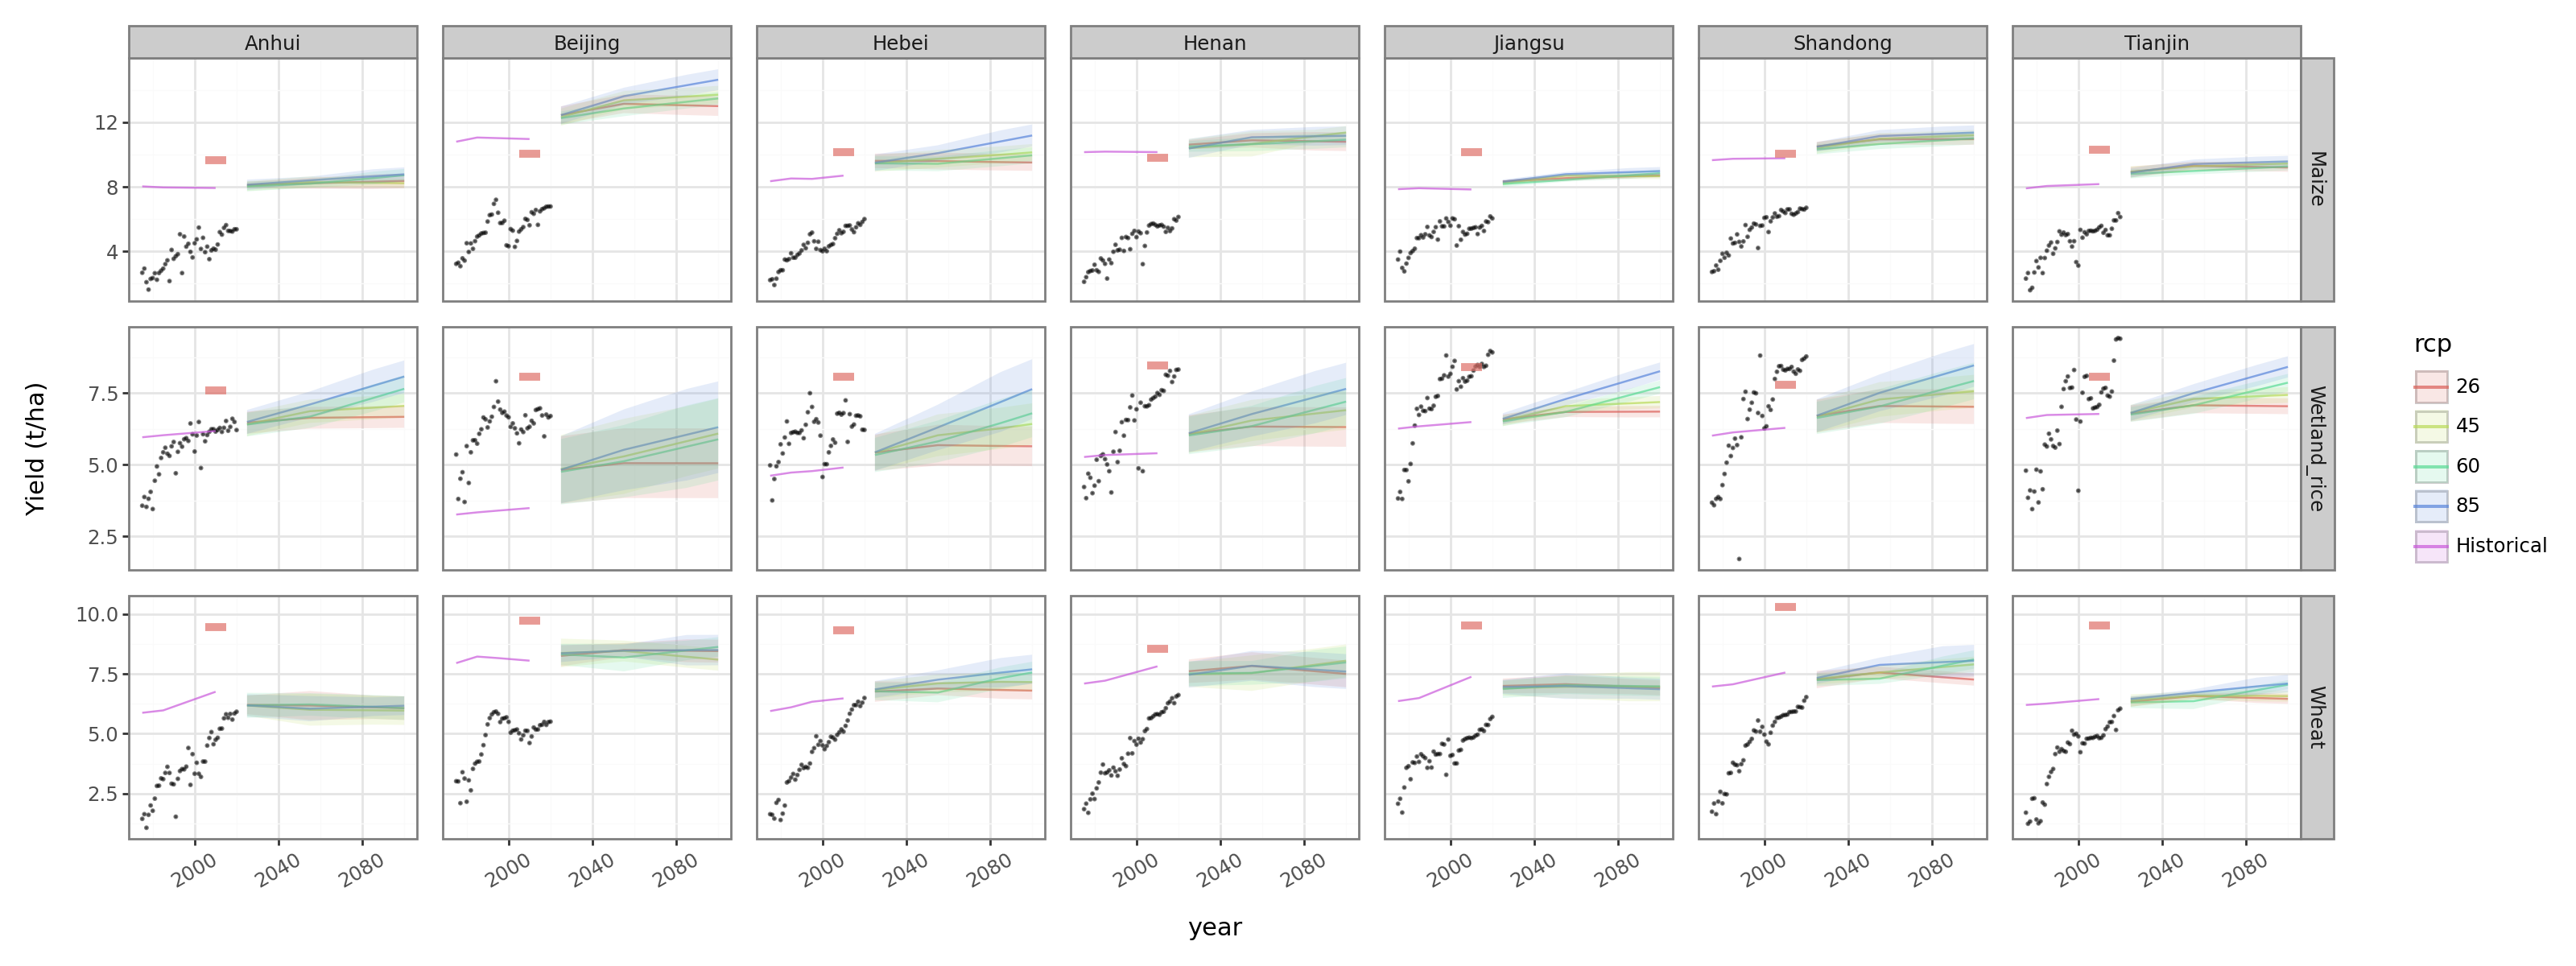

In [19]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 # yearbook yield
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production'),alpha=0.5,size=0.2) +
 # GAEZ_yield
 geom_line(anchor_attainable_converted_df, aes('year','Mean Production',color='rcp'),alpha=0.7) +
 geom_ribbon(anchor_attainable_converted_df, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.15) +
 # GYGA_yield
 geom_line(GYGA_with_area_ratio, aes('year','Mean Production'),size=2,color='#de6f67',alpha=0.7) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

g